In [2]:
import katdal
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import h5py
import time
%matplotlib inline

## Getting the statics of H5 files

In this script we are going to get the statistics of RFI for visibility observations.

## Opening the file

In [3]:
# List of files
file_list =['/var/kat/archive2/data/MeerKATAR1/telescope_products/2018/02/18/1518913830.h5']
flag_list = ['/var/kat/archive3/data/MeerKATAR1/reduction_products/1518934283/1518913830_flags.h5']

In [5]:
# Opening multi h5 files and corresponding flags
mult_h5 = [katdal.open(i) for i in file_list]
flags = [h5py.File(i,'r') for i in flag_list]

In [6]:
def apply_TomAO(mult_h5,flags):
    '''
    This function is going to apply TOM flags on the original file
    
    Input : List of h5 files and list of the corresponding flags
    
    Output : This function returns nothing, but modifies the existing data set in-place.
    '''
    for i in range(len(flags)):
        # Updating flags on the datafile
        mult_h5[i]._flags = flags[i]['flags'] 
        #data = np.ma.array(h5.vis[:,:,:],mask=h5.flags[:])

In [7]:
# Apply TOM flags on the datafile
apply_TomAO(mult_h5,flags)

## Inspecting the content of the file

In [73]:

print mult_h5[0]

Name: /var/kat/archive2/data/MeerKATAR1/telescope_products/2018/02/18/1518913830.h5 (version 3.0)
Observer: BHugo  Experiment ID: 20180217-0011
Description: 'COMM-238 3C286/PKS1934-638 Boresight Polarization Calibration'
Observed from 2018-02-18 02:30:31.143 SAST to 2018-02-18 07:37:43.346 SAST
Dump rate / period: 0.12505 Hz / 7.997 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m002,m003,m007,m008,m011,m012,m013,m019,m022,m025,m027,m029,m034,m035,m041  32      544
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M4k    1284.000         856.000           4096       208.984
-------------------------------------------------------------------------------
Data selected according to the following criteria:
  corrprods='cross'
  pol=['HH', 'VV', 'HV', 'VH']
  subarray=0
  scans='track'
  spw=0
-------------------------------------------------------------------------------
Shape: (2248 dump

In [9]:
def corr_prod(h5,cross = False,auto=False):
    '''
    This function is going to choose the type of correlation product that you need.
    It is either you choose cross correlation for anntena pairs, or auto correlation for anntena with itself.
    
    Input : H5 file 
    
    Output : Subset of H5 file dataset selected.
    '''
    if cross:
        h5.select(corrprods = 'cross',pol = ['HH','VV','HV','VH'],scans='track')
    if auto:
        h5.select(corrprods = 'auto',pol = ['HH','VV','HV','VH'],scans='track')
        

In [10]:
# Selecting a subset of the dataset
corr_prod(mult_h5[0],cross = True,auto=False)

In [11]:
def baselines(h5):
    '''
    This function is going to compute the number of baselines in an observetion.
    
    Input : h5 file
    
    Output : number baselines
    '''
    no_of_ants = len(h5.ants)
    
    no_of_baselines = (no_of_ants * (no_of_ants -1))/2
    
    return no_of_baselines
    

In [12]:
no_of_baselines = baselines(mult_h5[0])

In [70]:
def flags_per_pol(h5,no_of_baselines):
    '''
    This function is going to compute the flags of each polarization
    
    Input : h5 file and number of baselines
    
    Output : List of flags for each polarization in order [HH,VV,HV,VH]
    '''
    
    HH = h5.flags[:,:,0:no_of_baselines]
    stop = 2*no_of_baselines
    VV = h5.flags[:,:,no_of_baselines:stop]
    stop2 = 3*no_of_baselines
    HV = h5.flags[:,:,stop:stop2]
    stop3 = 4*no_of_baselines
    VH = h5.flags[:,:,stop2:stop3]
    
    
  
    
    return [HH,VV,HV,VH]

In [71]:
start = time.time()
flagsPol = flags_per_pol(mult_h5[0],no_of_baselines)
print 'time', time.time() - start

time 48.1619799137


In [28]:
# Converting frequency to MHz
freqs = mult_h5[0].freqs/1000000

In [25]:
def rfi_probability_freq(msk):
    '''
    This function is going to compute the probability of seeing an rfi given
    frequency channel.The probabilities are going to be averaged over time.
    The files must have the same number frequency channels.
    
    Input: List of RFI mask
    
    Output: numpy array of the computed probabilities.
    '''
    # Computing Probability of RFI occupancy given frequency channel
    freq = []
    # looping throgh baseline
    for j in range(msk.shape[2]): 
        tmp = []
        for i in range(msk.shape[1]): # looping through frequency channels
        #Getting the rfi index and summing them
            tmp.append(np.size(np.where(msk[:,i,j]==True)))
            
        freq.append(tmp)
        
    # Converting the list into numpy array
    p = np.array(freq)
    
    
    p = sum(p)
    
    
    # computing probabilities averanging over frequency channels
    prob_freq=p/(float(msk.shape[0]*msk.shape[2]))  # len of time x number of baseline
    
    return prob_freq

In [26]:
# Evaluating the probabilities per each polarization
freqHH =rfi_probability_freq(flagsPol[0])
freqVV =rfi_probability_freq(flagsPol[1])
freqVH = rfi_probability_freq(flagsPol[2])
freqHV = rfi_probability_freq(flagsPol[3])

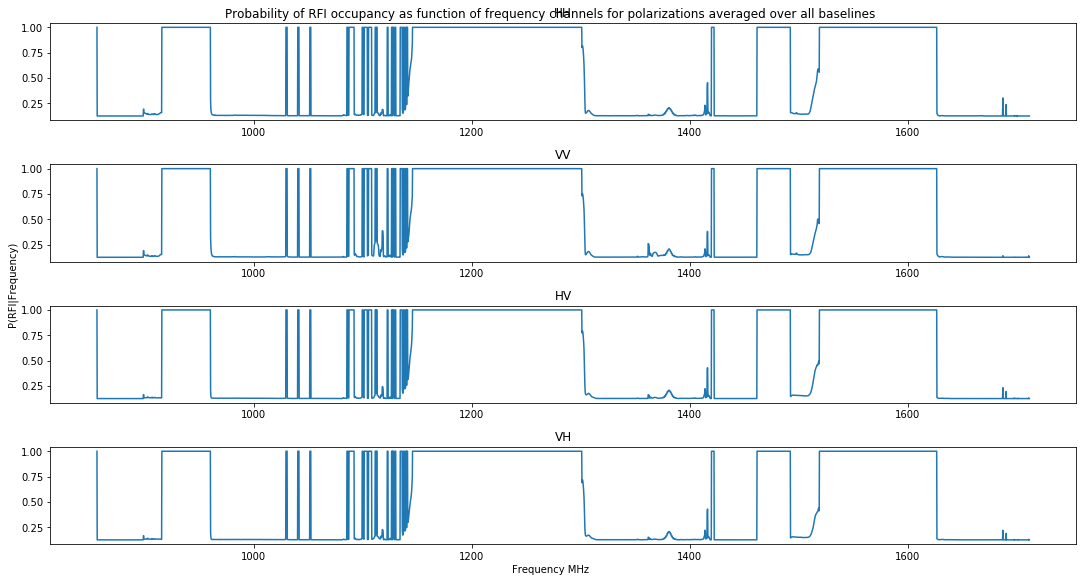

In [29]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(411)
ax1.set_title('HH')
ax2 = fig.add_subplot(412)
ax2.set_title('VV')
ax3 = fig.add_subplot(413)
ax3.set_title('HV')
ax4 = fig.add_subplot(414)
ax4.set_title('VH')

ax1.plot(freqs,freqHH)
ax2.plot(freqs,freqVV)
ax3.plot(freqs,freqVH)
ax4.plot(freqs,freqHV)

# Set common labels
fig.text(0.5, 0.004, 'Frequency MHz', ha='center', va='center')
fig.text(0.002, 0.5, 'P(RFI|Frequency)', ha='center', va='center', rotation='vertical')
fig.suptitle('Probability of RFI occupancy as function of frequency channels for polarizations averaged over all baselines')



fig.tight_layout()
plt.show()

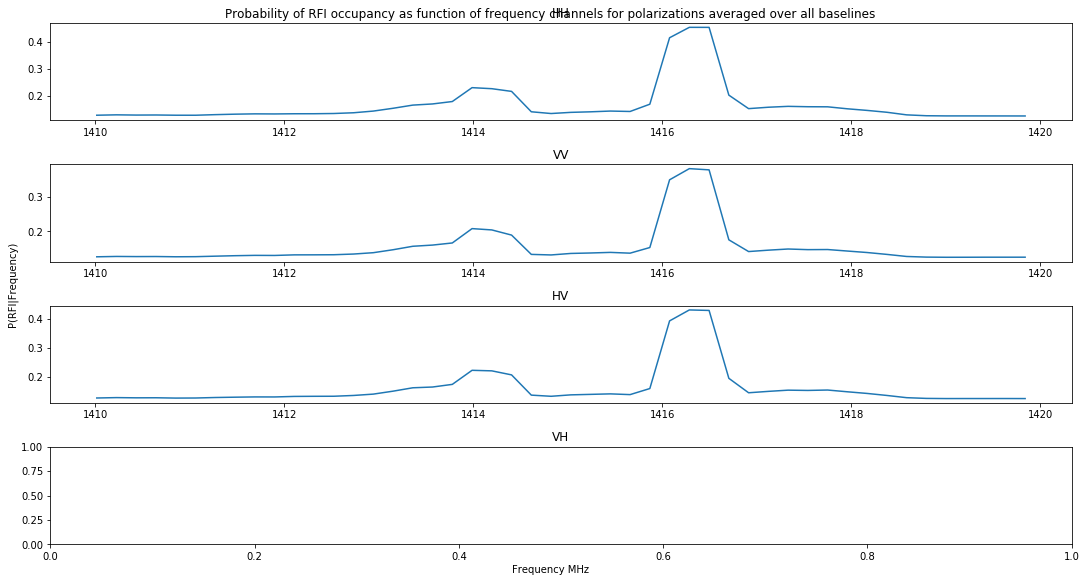

In [56]:
# Now checking all selected frequency band
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(411)
ax1.set_title('HH')
ax2 = fig.add_subplot(412)
ax2.set_title('VV')
ax3 = fig.add_subplot(413)
ax3.set_title('HV')
ax4 = fig.add_subplot(414)
ax4.set_title('VH')

ax1.plot(freqs[np.where((freqs>1410) & (freqs<1420))[0]],freqHH[np.where((freqs>1410) & (freqs<1420))[0]])
ax2.plot(freqs[np.where((freqs>1410) & (freqs<1420))[0]],freqVV[np.where((freqs>1410) & (freqs<1420))[0]])
ax3.plot(freqs[np.where((freqs>1410) & (freqs<1420))[0]],freqVH[np.where((freqs>1410) & (freqs<1420))[0]])
#ax4.plot(freqs,freqHV)

# Set common labels
fig.text(0.5, 0.004, 'Frequency MHz', ha='center', va='center')
fig.text(0.002, 0.5, 'P(RFI|Frequency)', ha='center', va='center', rotation='vertical')
fig.suptitle('Probability of RFI occupancy as function of frequency channels for polarizations averaged over all baselines')



fig.tight_layout()
plt.show()